In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from neuralNet1 import NeuralNet
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from PIL import Image
import os
from customDataset import CustomDataset
from torch.utils.data import DataLoader
from scipy.ndimage import convolve
from FourierLoss import BandFilterLoss, BandFilterLossTorch, FourierHeatMap


In [2]:
### Check if GPU is available

if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using GPU")
else:
    device = torch.device("cpu")
    print("Using CPU")

# Check for GPU availability and set device
if torch.cuda.is_available():
    device_count = torch.cuda.device_count()
    device = torch.device("cuda")
    current_device_idx = torch.cuda.current_device()
else:
    device_count = 0
    device = torch.device("cpu")
    current_device_idx = None

# Print device information
print(f"Number of available GPUs: {device_count}")
print(f"Current device index: {current_device_idx}")
# print(f"Current device name: {torch.cuda.get_device_name(current_device_idx)}")

Using CPU
Number of available GPUs: 0
Current device index: None


In [24]:
# Load the model
weights = os.listdir("Model_Weights")
weight = "Model_Weights/"+weights[3]
model = NeuralNet()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
checkpoint = torch.load(weight,map_location=torch.device('cpu'))
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']
model.to(device)
print(weight)

Model_Weights/semi_checkpoint2.pth


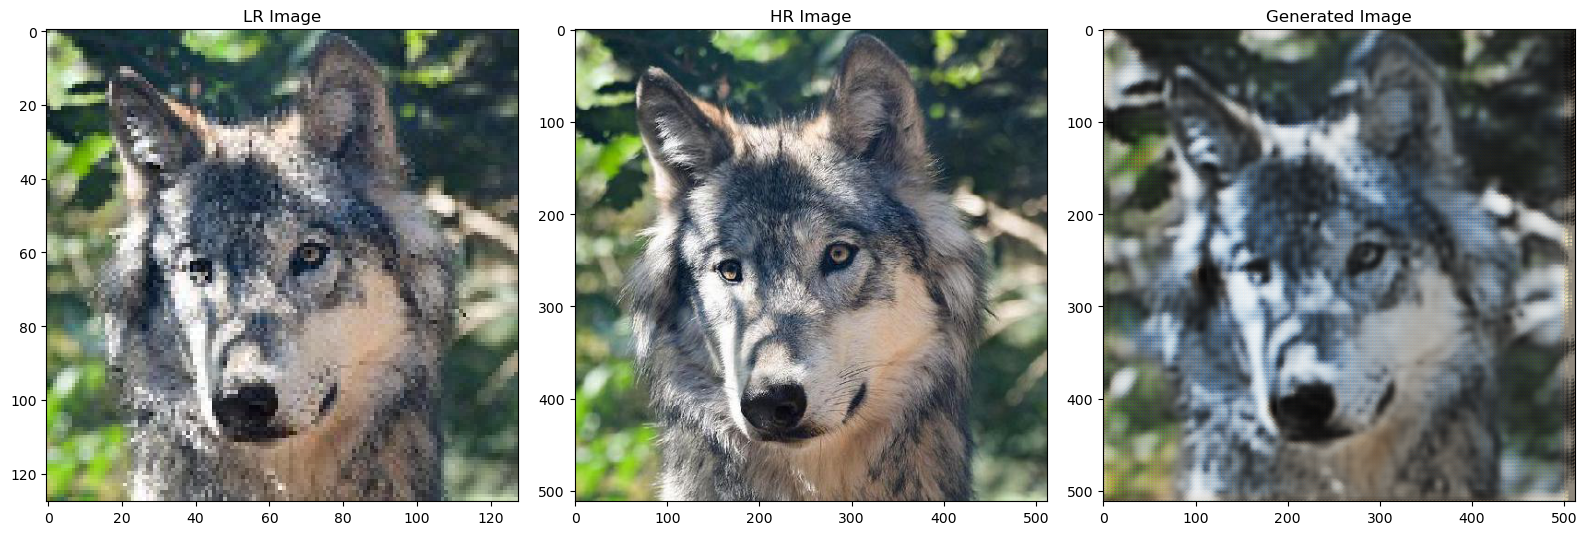

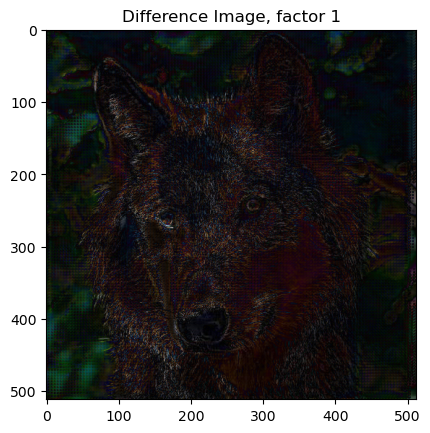

Overall MSE: 0.008610102638714928
MSE: 0.010483465785019587
MSE: 0.00789271670366791
MSE: 0.007454125427457289


In [41]:
#Inference and Analysis
# Get sample target image, input image, output image, and difference between target and output images
def enhance(lr_image):#apply model to lr image
    transform = transforms.Compose([
        transforms.ToTensor()
    ])

    # Set the model to evaluation mode
    model.eval()

    image = plt.imread(lr_image)
    image = Image.fromarray(image)
    input_image = transform(image)

    # Perform the inference
    with torch.no_grad():
        input_image = input_image.to(device)  # Move the input image to the device
        input_image = input_image.unsqueeze(0)  # Add a batch dimension
        output = model(input_image)

    # Convert to numpy array
    output = output.squeeze(0).cpu().detach().numpy()

    # Change the order of the dimensions from (C, H, W) to (H, W, C)
    output = np.transpose(output, (1, 2, 0))
    output_im = np.array(output*255,dtype=int)
    return output_im

def compare(lr_image,hr_image):#compares LR, HR, Generated from LR
    # Create a figure with subplots
    fig, axes = plt.subplots(1, 3, figsize=(16, 8))

    # Display images in subplots
    input_image = plt.imread(lr_image)
    target_image = plt.imread(hr_image)
    output_image = enhance(lr_image)

    axes[0].imshow(input_image)
    axes[0].set_title('LR Image')

    axes[1].imshow(target_image)
    axes[1].set_title('HR Image')

    axes[2].imshow(output_image)
    axes[2].set_title('Generated Image')

    # Adjust spacing between subplots
    plt.tight_layout()

    # Show the plot
    plt.show()

    difference_image = abs(output_image - target_image)
    factor = 1
    plt.imshow(difference_image*factor) # multiply by 2 to make the difference more visible
    plt.title("Difference Image, factor "+ str(factor))
    plt.show()

    # find mse between original and reconstructed image
    mse = np.mean((difference_image/255)**2)
    print("Overall MSE:", mse)
    for i in range(3):
        channel_diff_img = difference_image[:,:,i]
        mse = np.mean((channel_diff_img/255)**2)
        print("MSE:", mse)
    return target_image,output_image,difference_image

pictures = {
    'tiger':("LR_images/ci/downscaled_ci_flickr_wild_002021.jpg","HR_images/flickr_wild_002021.jpg"),
    'dog':("LR_test/downscaled_ci_pixabay_dog_001489.jpg","HR_test/pixabay_dog_001489.jpg"),
    'wolf':("LR_test/downscaled_ci_pixabay_wild_000639.jpg","HR_test/pixabay_wild_000639.jpg"),
    'wave':("extraPics/downscaled_ci_waves.jpg","extraPics/waves.jpg"),
    'Ryan':("Ryan1.jpg","Ryan2.jpg")
}
lr, hr = pictures['wolf']
target,output,difference = compare(lr, hr)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


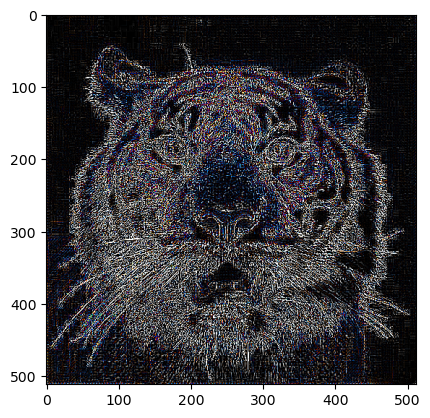

In [5]:
## some conv attempts -- Sobel Kernel##
#image = transform.ToPILImage()(image)
'''
v_kernel is conv kernel to detect vertical edges, similar for h_kernel
sobel kernel is a specific kernel that also detects edges
'''
# v_kernel = np.array([[[-2,-2,-2],[-1,-1,-1],[0,0,0],[1,1,1],[2,2,2]],
#                      [[-2,-2,-2],[-1,-1,-1],[0,0,0],[1,1,1],[2,2,2]],
#                      [[-2,-2,-2],[-1,-1,-1],[0,0,0],[1,1,1],[2,2,2]],
#                      [[-2,-2,-2],[-1,-1,-1],[0,0,0],[1,1,1],[2,2,2]],
#                      [[-2,-2,-2],[-1,-1,-1],[0,0,0],[1,1,1],[2,2,2]]])
# v_kernel = np.array([[[-1,-1,-1],[0,0,0],[1,1,1]],
#                      [[-2,-2,-2],[0,0,0],[2,2,2]],
#                      [[-1,-1,-1],[0,0,0],[1,1,1]]])
# h_kernel = np.transpose(v_kernel,(1,0,2))
kernel = np.array([[[-1,-1,-1],[-1,-1,-1],[-1,-1,-1]],
                     [[-1,-1,-1],[8,8,8],[-1,-1,-1]],
                     [[-1,-1,-1],[-1,-1,-1],[-1,-1,-1]]])

target = difference_image
contrasted = convolve(target,kernel)
plt.imshow(contrasted)
plt.show()
# target_v_edges = convolve(target, v_kernel)
# target_h_edges = convolve(target,h_kernel)
# target_avg = (target_v_edges + target_h_edges)//2

# generated_v_edges = convolve(output_im, v_kernel)
# generated_h_edges = convolve(output_im,h_kernel)
# generated_avg = (generated_h_edges+generated_v_edges)//2
# Create a figure with subplots
# fig, axes = plt.subplots(2, 4, figsize=(16, 8))

# # Display images in subplots
# axes[0][0].imshow(target)
# axes[0][0].set_title('Target Image')
# axes[1][0].imshow(output_im)
# axes[1][0].set_title('Generated Image')

# axes[0][1].imshow(target_v_edges)
# axes[0][1].set_title('Vertical Edges')
# axes[1][1].imshow(generated_v_edges)
# axes[1][1].set_title('Vertical Edges')

# axes[0][2].imshow(target_h_edges)
# axes[0][2].set_title('Horizontal Edges')
# axes[1][2].imshow(generated_h_edges)
# axes[1][2].set_title('Horizontal Edges')

# axes[0][3].imshow(target_avg)
# axes[0][3].set_title('Both Edges')
# axes[1][3].imshow(generated_avg)
# axes[1][3].set_title('Both Edges')

# # Adjust spacing between subplots
# plt.tight_layout()
# # Show the plot
# plt.show()

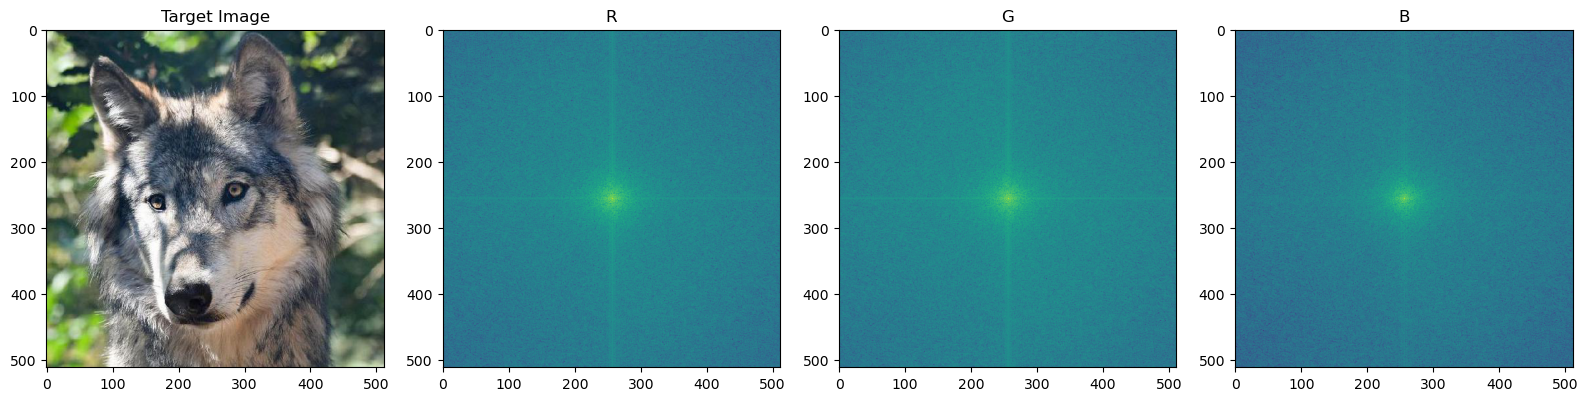

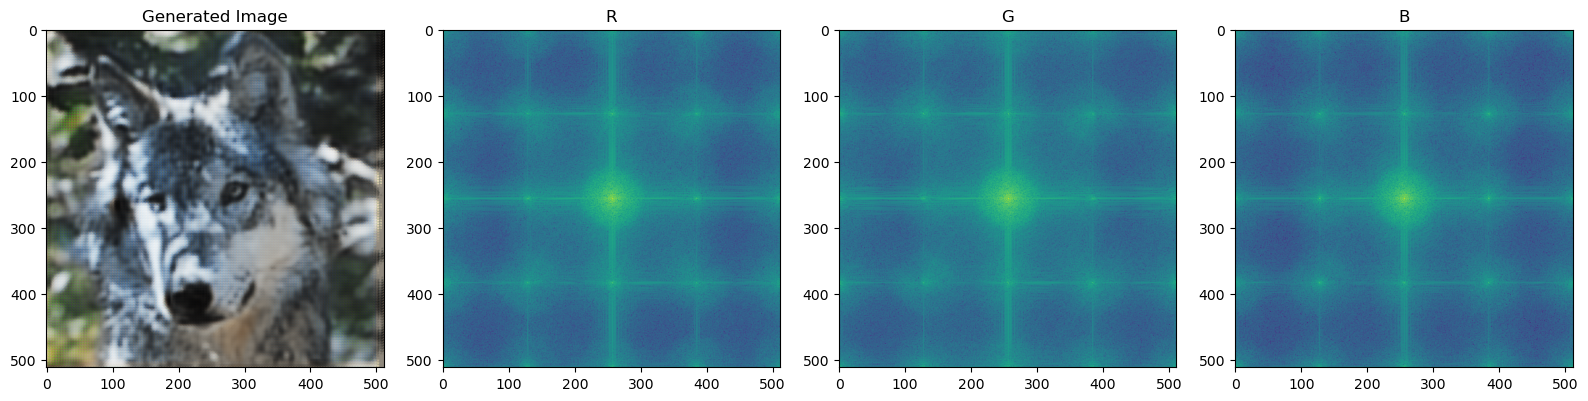

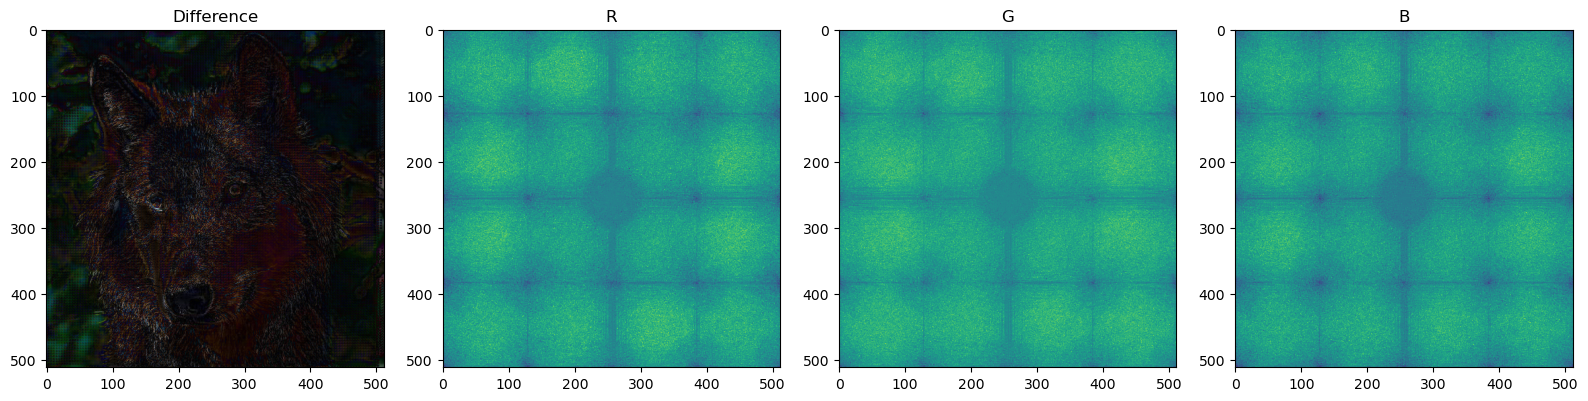

Fourier MSE: 4.227290534880872


In [42]:
# Fourier Analysis
def fourier_map(img,title,display=True):
    
    r = img[:,:,0]
    g = img[:,:,1]
    b = img[:,:,2]

    # Perform Fourier Transform for each color channel
    r_fft = np.fft.fftshift(np.fft.fft2(r))
    g_fft = np.fft.fftshift(np.fft.fft2(g))
    b_fft = np.fft.fftshift(np.fft.fft2(b))

    # Compute magnitude spectra for each color channel
    r_magnitude_spectrum = 32*np.log(np.abs(r_fft))
    g_magnitude_spectrum = 32*np.log(np.abs(g_fft))
    b_magnitude_spectrum = 32*np.log(np.abs(b_fft))

    # Display the original image and magnitude spectra for each color channel
    # Create a figure with subplots

    if display:
        fig, axes = plt.subplots(1, 4, figsize=(16, 8))
        # Display images in subplots
        axes[0].imshow(img)
        axes[0].set_title(title)
        axes[1].imshow(r_magnitude_spectrum)
        axes[1].set_title('R')
        axes[2].imshow(g_magnitude_spectrum)
        axes[2].set_title('G')
        axes[3].imshow(b_magnitude_spectrum)
        axes[3].set_title('B')
        plt.tight_layout()
        plt.show()
    return r_magnitude_spectrum,g_magnitude_spectrum,b_magnitude_spectrum

rt,gt,bt = fourier_map(target,"Target Image")
ro,go,bo = fourier_map(output,"Generated Image")
r_diff,g_diff,b_diff = rt-ro,gt-go,bt-bo
fig, axes = plt.subplots(1,4,figsize=(16,8))
axes[0].imshow(difference)
axes[0].set_title("Difference")
axes[1].imshow(r_diff)
axes[1].set_title('R')
axes[2].imshow(g_diff)
axes[2].set_title('G')
axes[3].imshow(b_diff)
axes[3].set_title('B')
plt.tight_layout()
plt.show()

loss_function = FourierHeatMap()
mse = loss_function(target,output,False)
print("Fourier MSE:",mse)

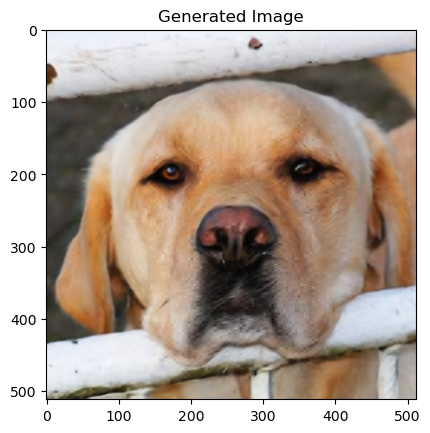

R 0 143
G 0 156
B 0 163
Full: 0 163
R 0 169
G 0 176
B 0 181
Full: 0 181
R 0 172
G 0 179
B 0 188
Full: 0 188


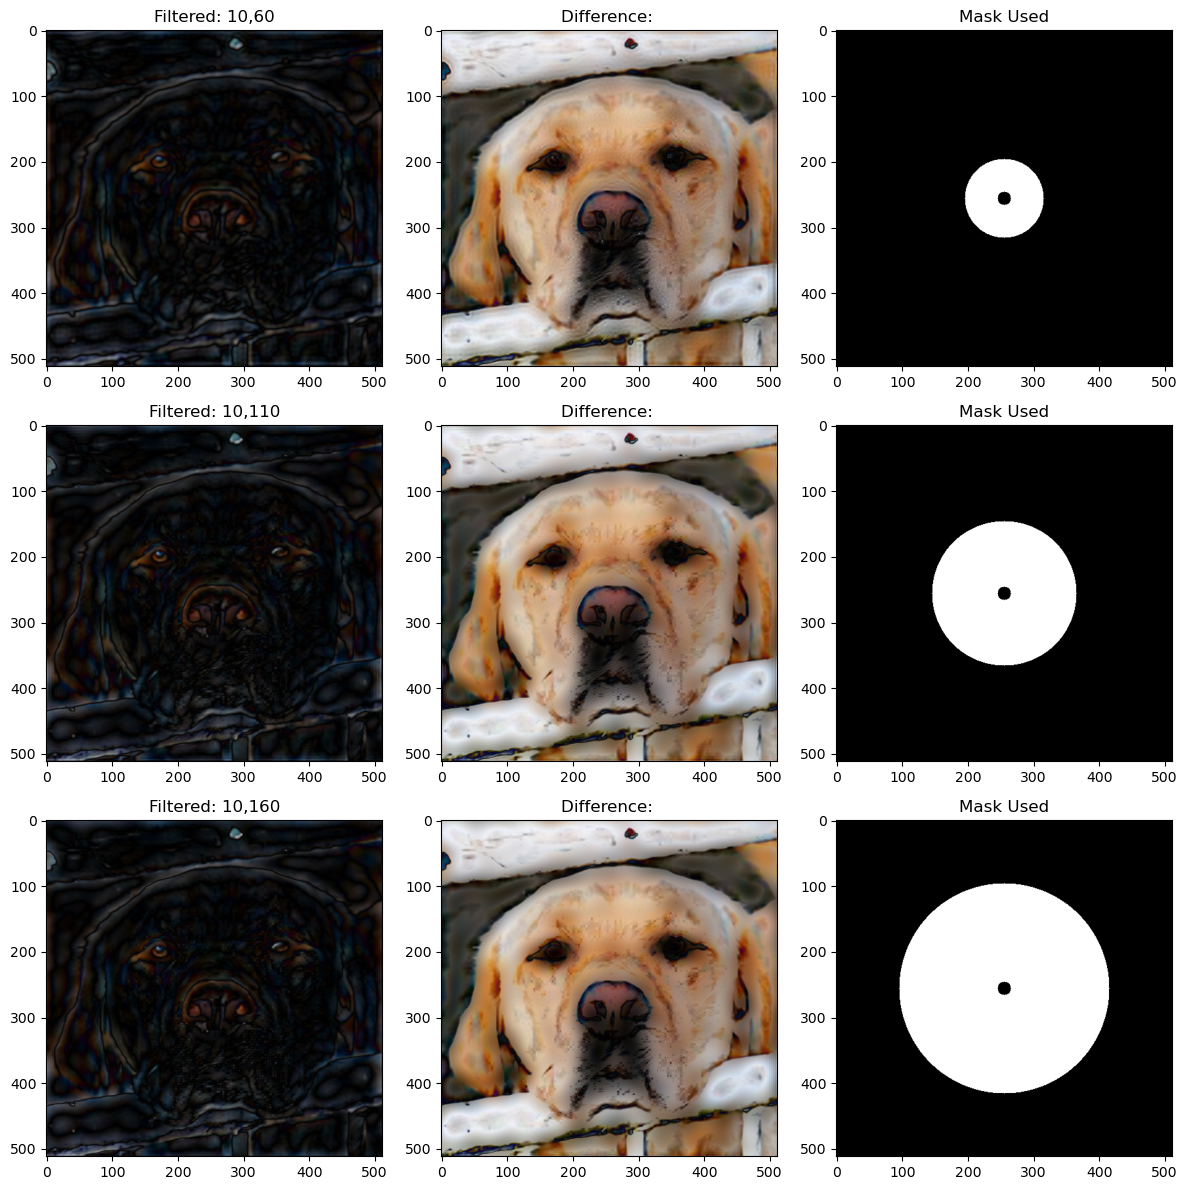

In [19]:
# Band Pass Fourier Filters 

def band_pass_channel(channel, mask,color):
    #transform to frequency domain with FFT
    f = np.fft.fft2(channel)
    f_shift = np.fft.fftshift(f)
    
    #mask specific frequencies
    f_shift_filtered = f_shift * mask
    
    #invert back to get new image
    f_inverse_shift = np.fft.ifftshift(f_shift_filtered)
    channel_filtered = np.fft.ifft2(f_inverse_shift)
    channel_filtered = np.abs(channel_filtered).astype(int)#remove imaginary part, and make sure integers
    return channel_filtered

def band_pass_filter(img,r1,r2):

    # Split the image into color channels
    r = img[:,:,0]
    g = img[:,:,1]
    b = img[:,:,2]
    
    rows, cols, depth = img.shape
    center_row, center_col = rows // 2, cols // 2#get center
    
    # # Create a circular mask
    mask = np.zeros((rows, cols), np.uint8)#get rid of everything
    mask = cv2.circle(mask, (center_col, center_row), r2, 1, -1)#actually keep disk of r2
    if r1>0:
        mask = cv2.circle(mask, (center_col, center_row), r1, 0, -1)    #actually get rid of inner disk again r1 (creating band)
    # plt.imshow(mask,cmap='gray')
    # plt.show()
    # print(mask)
    
    #mask each color
    r_filtered = band_pass_channel(r, mask,'R')
    g_filtered = band_pass_channel(g, mask,'G')
    b_filtered = band_pass_channel(b, mask,'B')
    #combine to one image
    filtered_image = cv2.merge((r_filtered, g_filtered, b_filtered))
    return filtered_image,mask


img = output_image
plt.imshow(img)
plt.title("Generated Image")
plt.show()
fig, axes = plt.subplots(3,3,figsize=(12,12))
for i in range(3):
    # inner = (i*(i+19)**2)//400
    inner=10
    outer = inner+50*(i+1)
    filtered,mask = band_pass_filter(img,inner,outer)
    change = abs(filtered - img)
    axes[i][0].imshow(filtered)
    axes[i][0].set_title("Filtered: " + str(inner)+","+str(outer))
    axes[i][1].imshow(change)
    axes[i][1].set_title("Difference: ")
    axes[i][2].imshow(mask,cmap='gray')
    axes[i][2].set_title("Mask Used")
plt.tight_layout()
plt.show()

# filtered,mask = high_pass_filter(img,30,100)
# plt.imshow(filtered)
# plt.show()

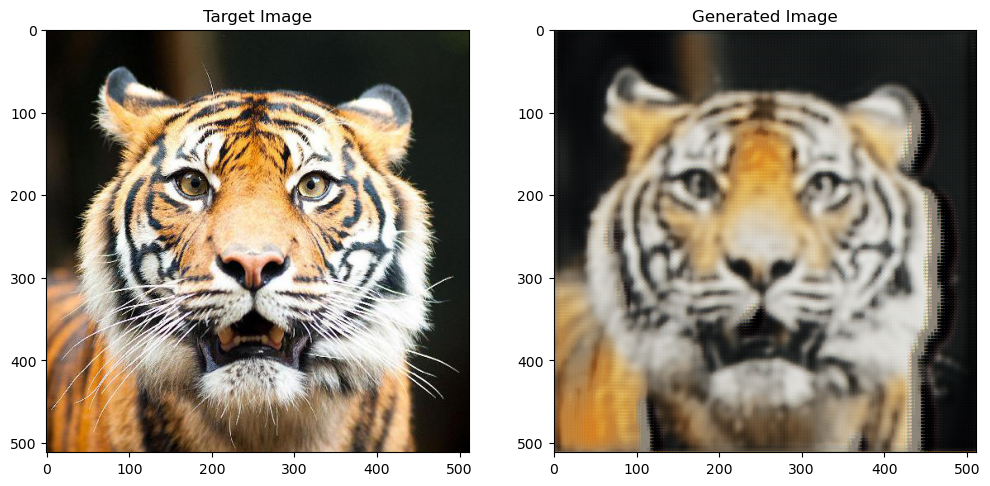

NameError: name 'band_pass_filter' is not defined

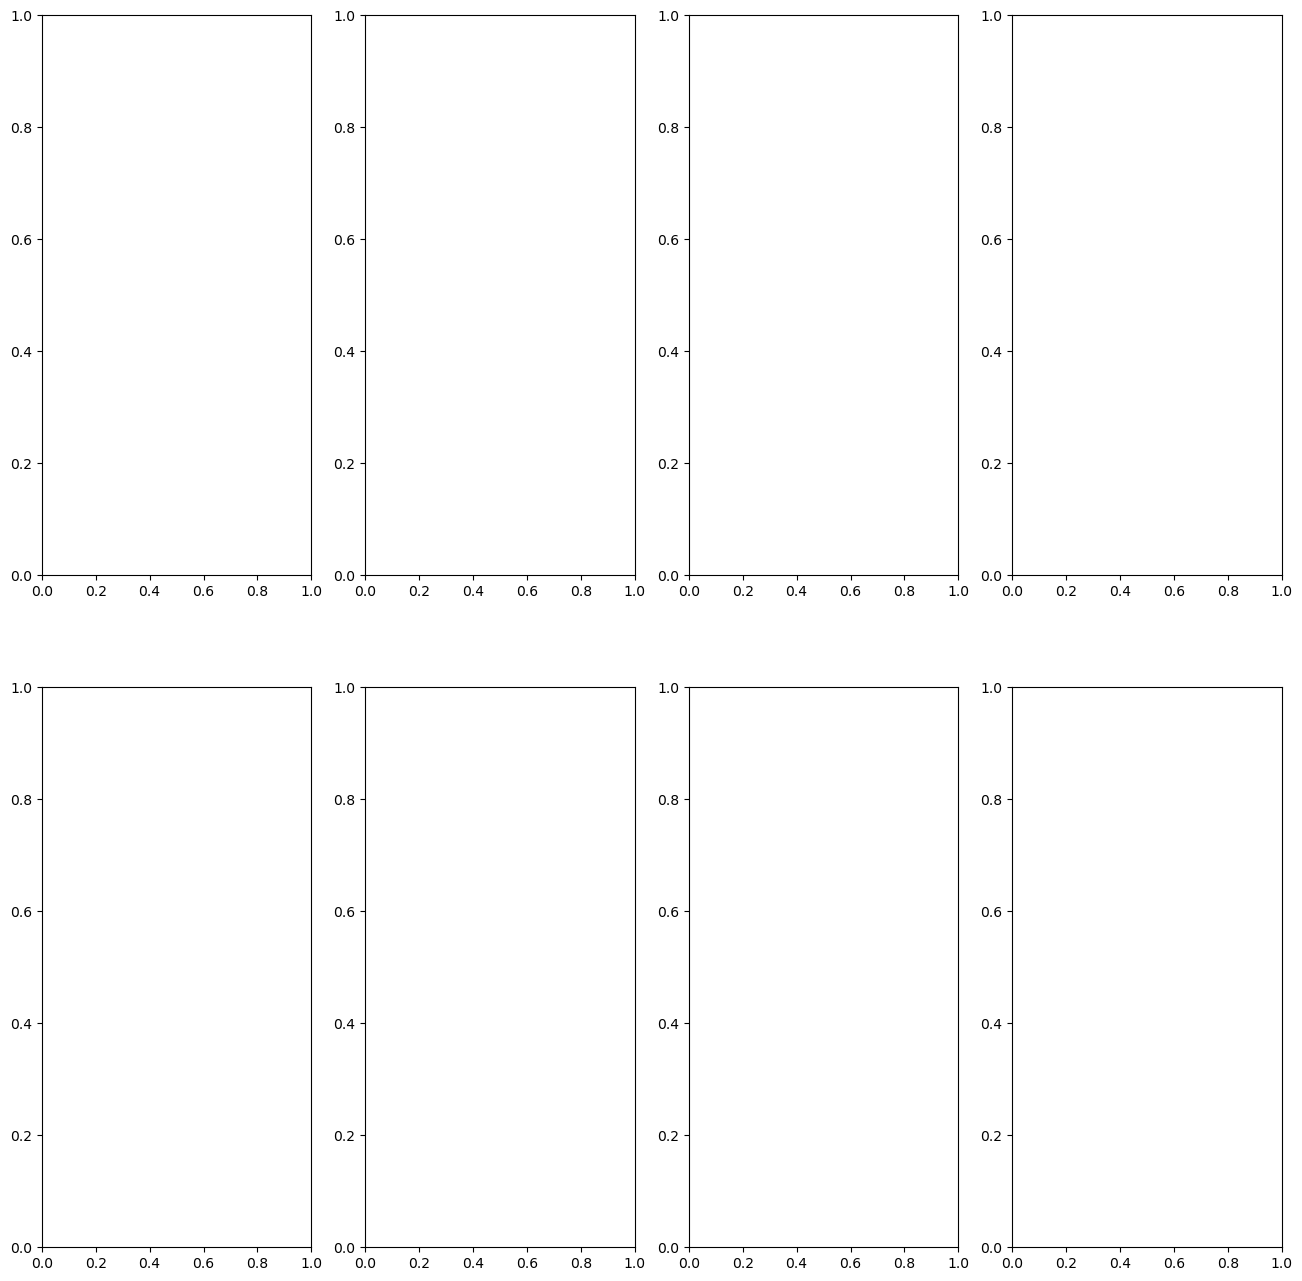

In [18]:
# Difference between target and generated image band pass filter

fig, axes = plt.subplots(1,2,figsize=(12,12))
axes[0].imshow(target_image)
axes[0].set_title("Target Image")
axes[1].imshow(output_image)
axes[1].set_title("Generated Image")
plt.show()

fig, axes = plt.subplots(2,4,figsize=(16,16))
for i in range(2):
    # inner = (i*(i+19)**2)//400
    # outer = inner+100*(i+1)
    inner= 0
    outer = 75*i+75
    target_filtered, target_mask = band_pass_filter(target_image,inner,outer)
    output_filtered, output_mask = band_pass_filter(output_image,inner,outer)
    change = abs(target_filtered - output_filtered)
    axes[i][0].imshow(target_filtered)
    axes[i][0].set_title("Filtered Target: " + str(inner)+","+str(outer))
    axes[i][1].imshow(output_filtered)
    axes[i][1].set_title("Filtered Output: ")
    axes[i][2].imshow(change)
    axes[i][2].set_title("difference:")
    axes[i][3].imshow(target_mask,cmap='gray')
    axes[i][3].set_title("Mask Used")
    print(np.min(target_filtered),np.max(target_filtered))
    # find MSE
    mse = np.mean((change)**2)
    print("MSE: ",mse)
    # use HiFilterLoss to find mse
    loss_fn = HiFilterLoss(inner,outer)
    loss = loss_fn(target_image, output_image)
    print("HiFilterLoss: ",loss)
plt.tight_layout()
plt.show()



# loss_fn2 = HiFilterLossTensor(20, 300)

# target_image_tensor = transform(target_image)
# output_image_tensor = transform(output_image)
# loss = loss_fn2(target_image, output_image)
# print("HiFilterLossTensor: ",loss)
